# Imports and Setting Seed


In [ ]:
#For the use of google colab. Connects to google drive, which acts as storage for loading files, data, and models. Comment this out if not using google colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Also for use of google colab. Imports packages that google colab does not have preinstalled.
!pip3 install segmentation_models_pytorch
!pip3 install warmup_scheduler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
#Import packages

import torch.utils.data as Data
import torch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as smp_losses
import segmentation_models_pytorch.utils as smp_utils
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import datetime
import random
import sys
from torch.optim.lr_scheduler import StepLR
from warmup_scheduler import GradualWarmupScheduler
from copy import deepcopy
import torchvision.utils as vutils
import ssl

In [ ]:
#Define GPU use
torch.set_num_threads(6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Define set seed

seed_cus = 1

random.seed(seed_cus)
np.random.seed(seed_cus)
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed_cus)



# Load Data

In [ ]:
#Define dataset class

import torch.utils.data as Data
class My_Datasets(Data.Dataset):
    def __init__(self, img_dir, mask_dir, transform1=None,transform2=None):
        super().__init__()

        #Set paths to the Cine and mask directory
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        #Get a list of all the files in the directories
        self.img_list = os.listdir(self.img_dir)
        self.mask_list = os.listdir(self.mask_dir)


        #Initialize transforms
        self.transform1 = transform1
        self.transform2 = transform2


    def __getitem__(self, index):

        #Define Cine file name
        img_name = self.img_list[index]

        #Define mask file name using the Cine file name so that that masks and Cine files are matched up
        mask_name = self.img_list[index].split('.')[0] + ".nii.png"

        #Read the .tiff file with 30 pages using cv2.imreadmulti instead of cv2.imread
        img_tuple = cv2.imreadmulti(os.path.join(self.img_dir,img_name), flags = cv2.IMREAD_COLOR) # here we load as RBG

        #cv2.imreadmulti returns a tuple of length two, with the second value of the tuple being the actual images
        img_list = img_tuple[1]

        #Get the first image from the list and perform all necessary operations.
        first_img = img_list[0]
        tuned = first_img/[255.0]
        tuned = cv2.resize(tuned,(224,224))
        tuned = tuned.astype(np.float32)
        tuned = self.transform1(tuned)

        combined_imgs = tuned.permute(1,2,0)


        #Because the first image was created, now in the for loop the other images can all just be stacked onto the first one with the same operations with an end shape of (90, 224, 224)
        #The channel number is 90 because each image has 3 channels, and there are 30 images, so when stacked channel wise the function returns an output with 3*30 = 90 channels
        for i in range(len(img_list)-1):


          img = img_list[i+1]
          LABImg = img/[255.0]
          LABImg = cv2.resize(LABImg,(224,224))
          LABImg = LABImg.astype(np.float32)
          LABImg = self.transform1(LABImg)

          combined_imgs = np.dstack((combined_imgs, LABImg.permute(1,2,0)))


        #Perform necessary operations on the mask
        mask= cv2.imread(os.path.join(self.mask_dir,mask_name))
        #Note here that mask is divided by 1 instead of 255 because the masks values range from 0-3 instead of 0-255 like the LGE/Cine images
        LABmask = mask/[1.0]
        LABmask = cv2.resize(LABmask,(224,224))
        LABmask = LABmask.astype(np.float32)
        LABmask = LABmask[:,:,0]
        LABmask = self.transform2(LABmask)


        #After creating the stacked images, flip them
        #This was to fix an error with the code that flipped the images(this is most likely due to an incorrect permutation earlier, but have not tested)
        #Only know that this code fixes the error
        combined_imgs = torch.from_numpy(combined_imgs)
        combined_imgs = torch.swapaxes(combined_imgs, 0, 2)
        combined_cines = torch.flip(torchvision.transforms.functional.rotate(combined_imgs, 270), [2])

        return combined_cines, LABmask, img_name

    def __len__(self):
        return len(self.img_list)


#Define transforms

transforms_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])
transforms_mask = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Define batch size, image paths, and create an object of the dataset class made above


img_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/Cine/'
mask_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/train_val/masks/'


batch_size_train = 8
batch_size_val = 8

train_set = My_Datasets(img_path,mask_path, transform1=transforms_img,transform2=transforms_mask)
n_train = len(train_set)
split = n_train // 5
a = list(range(n_train))

In [ ]:
#Load pickle files with indices meant for training vs testing

#NOT APPLICABLE IF THIS IS THE FIRST TIME RUNNING THE CODE
#BELOW CODE WILL CREATE THESE PICKLE FILES

with open('/content/drive/My Drive/Internship_24_Ryan/Heart/Indices/train_indices.pkl', 'rb') as f:
  train_indices = pickle.load(f)

with open('/content/drive/My Drive/Internship_24_Ryan/Heart/Indices/val_indices.pkl', 'rb') as f:
  val_indices = pickle.load(f)

In [ ]:
#Create training/validation splits and define the indices that are meant for training vs validation
#Save indices to pickle file(use above code if already generated pickle files)

names = os.listdir(img_path)

#Group patient files together so that all of a patient's files are in one group
#This is to later ensure that all patient files are only in either training, validation, or testing.
#This prevents the model from cheating by looking at similar images in both training and validation/testing
grouped_names = {}

for i in range(len(names)):
  base = names[i].split('_')[0]

  if names[i] not in blacklisted:
    if len(grouped_names) == 0:
      grouped_names[base] = [names[i]]
    else:
      if base in grouped_names:
        grouped_names[base] += [names[i]]
      else:
        grouped_names[base] = [names[i]]

indices = list(range(n_train))

#Attach an index to each file
for i in range(len(train_set)):
  tri = train_set[i]
  base = tri[2].split('_')[0]
  for x in range(len(grouped_names[base])):
    name = grouped_names[base][x]
    if name == tri[2]:
      grouped_names[base][x] = [name, i]



In [ ]:

#Get indices for training, validation, and testing.
length = len(train_set)
val_len = length // 4

train_indices = []
val_indices = []

train_names = []
val_names = []

train_len = length - val_len
for patient in grouped_names:
  while len(train_indices) < train_len:
    for index in range(len(grouped_names[patient])):

      train_indices += [grouped_names[patient][index][1]]
      train_names += [grouped_names[patient][index][0]]

    break

  else:
    while len(val_indices) < val_len:
      for index in range(len(grouped_names[patient])):
        val_indices += [grouped_names[patient][index][1]]
        val_names += [grouped_names[patient][index][0]]
      break



In [ ]:

#check to make sure no indices are repeated
for name in train_indices:
  if name in val_indices:
    print("DUPLICATE EXISTS!")
    print(name)

#check to make sure no patients have images in both the training and testing
train_bases = set()
val_bases = set()

for name in train_names:
  base = name.split('_')[0]
  train_bases.add(base)
for name in val_names:
  base = name.split('_')[0]
  val_bases.add(base)

for base in train_bases:
  if base in val_bases:
    print("ERROR")
    print(base)

In [ ]:
# define fixed seed
random.seed(seed_cus)
# define fixed seed
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)
indices = random.sample(a, len(a))

#Given a list of indices meant for training, create a Dataloader that will create a training set and batches
#Do the same for validation as well


train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)

# define fixed seed
torch.manual_seed(seed_cus)
torch.cuda.manual_seed(seed_cus)
torch.cuda.manual_seed_all(seed_cus)

valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = Data.DataLoader(
    dataset=train_set,
    sampler=train_sampler,
    num_workers=0,
    batch_size=batch_size_train,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g)
valid_loader = Data.DataLoader(
    dataset=train_set,
    sampler=valid_sampler,
    num_workers=0,
    batch_size=batch_size_val,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g)


# Loading Pretrained Senet154 Weights

In [ ]:
#Allow Senet154 to be loaded
ssl._create_default_https_context = ssl._create_unverified_context

# Load an SeNet154 through the smp.Unet library

#CHANGE BACKBONE HERE!!!

#Replace 'senet154' with 'resnet50' or different backbones. See full list of available backbones in the segmentation_models_pytorch library. NOTE: Resnet50 is much faster to load than an senet154.
model_phx = smp.Unet('senet154',encoder_weights='imagenet', in_channels=90, classes=4)

#Send model to GPU
model_phx= nn.DataParallel(model_phx)
model_phx.to(device)


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth" to /root/.cache/torch/hub/checkpoints/senet154-c7b49a05.pth
100%|██████████| 440M/440M [21:36<00:00, 356kB/s]


DataParallel(
  (module): Unet(
    (encoder): SENetEncoder(
      (layer0): Sequential(
        (conv1): Conv2d(90, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu3): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      )
      (layer1): Sequential(
        (0): SEBottleneck(
          (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fa

# Define Training

In [ ]:
#Define training
def train(epoch, alpha, beta):
    loss_sum = 0
    prev_time = time.time()
    for i, (images, masks, names) in enumerate(train_loader):

        #Send both imgs and masks to GPU
        imgs = images.to(device=device,dtype=torch.float32)
        masks = masks.to(device=device,dtype=torch.float32)

        #Turn masks from type Torch.Tensor to Torch.LongTensor
        #Why? Not sure, but it throws an error if masks aren't type LongTensor
        masks = masks.long()

        #Use model to predict on the images
        masks_pred = model_phx(imgs)


        #Calculate loss
        loss_seg = alpha * criterion_FA(masks_pred, masks)
        loss_all = loss_seg
        iter_loss = loss_all.data.item()
        loss_sum += loss_all.item()


        #Calculate gradients and begin backwards propagation
        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()


        #Print output of each batch and epoch
        batches_done = epoch * len(train_loader) + i
        batches_left = num_epoch * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [loss_seg: %f] [loss: %f]  ETA: %s"
            % (
                epoch,
                num_epoch,
                i,
                len(train_loader),
                loss_seg.item(),
                loss_all.item(),
                time_left,
            )
        )


# Define validation
def val(epoch, alpha, beta):
    #Define variables
    loss_sum = 0
    global best_seg_loss
    running_loss_all = 0.0
    running_loss_seg = 0.0
    prev_time = time.time()

    for i, (images, masks, names) in enumerate(valid_loader):
        #Send images and masks to GPU
        imgs = images.to(device=device,dtype=torch.float32)
        masks = masks.to(device=device,dtype=torch.float32)
        batch_size = imgs.shape[0]


        #Turn masks into type LongTensor, see explanation in train function
        masks = masks.long()

        with torch.no_grad():
            #Set to eval so weights don't change
            model_phx.eval()


            #Predict
            masks_pred = model_phx(imgs)

            #Calculate loss
            loss_seg = alpha * criterion_FA(masks_pred, masks)
            loss_all = loss_seg
            iter_loss = loss_all.data.item()
            loss_sum += loss_all.item()
            running_loss_seg += loss_seg.item() * batch_size
            running_loss_all += loss_all.item() * batch_size

            #Print output loss for the validation stage of an epoch
            batches_done = epoch * len(valid_loader) + i
            batches_left = num_epoch * len(valid_loader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()

            sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [loss_seg: %f] [loss: %f]  ETA: %s"
            % (
                epoch,
                num_epoch,
                i,
                len(valid_loader),
                loss_seg.item(),
                loss_all.item(),
                time_left,
            )
        )


    # len of valid_loader here is the total number of image, thus divided by 10
    epoch_loss_seg = running_loss_seg / (len(valid_loader.dataset)/5)
    epoch_loss_all = running_loss_all / (len(valid_loader.dataset)/5)

    # skip one line
    keyword = os.linesep
    print(keyword)

    sys.stdout.write(
        "[Epoch %d/%d] [loss_seg: %f] [loss: %f]"
        % (
            epoch,
            num_epoch,
            epoch_loss_seg,
            epoch_loss_all,
        )
    )

    #If the model loss is the best so far, save it
    epoch_loss_seg_adj = epoch_loss_seg/alpha
    if epoch_loss_seg_adj < best_seg_loss:
        best_seg_loss = epoch_loss_seg_adj
        torch.save(model_phx.state_dict(), '/content/drive/My Drive/Internship_24_Ryan/Heart/Models/Cine_baseline.pt')

In [ ]:
# Define training parameters here
# Experiment with different losses, optimizers, learning rate, epochs
# Adam and dice loss in general were found to be the best

num_epoch = 50
learning_rate = 1e-4

criterion_FA = smp_losses.dice.DiceLoss(smp_losses.MULTICLASS_MODE, from_logits=True) # new loss (multi) in losses
optimizer = optim.Adam(model_phx.parameters(),
                           lr=learning_rate)

scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=2, total_epoch=5, after_scheduler=scheduler_cosine)
device = torch.device('cuda')



# Training

In [ ]:
#Training


#Send loss to GPU
criterion_FA = criterion_FA.cuda()

alpha = 1.0
beta = 0.0


best_seg_loss = 999999
for epoch in range(num_epoch):
    print('Starting training epoch {}/{}.'.format(epoch + 1, num_epoch))
    model_phx.train()
    train(epoch, alpha, beta)
    scheduler_warmup.step()
    print(scheduler_warmup.get_lr())
    print('Starting validation epoch {}/{}.'.format(epoch + 1, num_epoch))
    model_phx.eval()
    val(epoch, alpha, beta)
    print(scheduler_warmup.get_lr())
    print('Best adjusted seg loss for validation dataset: {}.'.format(best_seg_loss))

Starting training epoch 1/50.
[Epoch 0/50] [Batch 47/48] [loss_seg: 0.816570] [loss: 0.816570]  ETA: 1:17:00.154824[0.00012]
Starting validation epoch 1/50.
[Epoch 0/50] [Batch 15/16] [loss_seg: 0.813025] [loss: 0.813025]  ETA: 0:08:53.592119

[Epoch 0/50] [loss_seg: 0.994354] [loss: 0.994354][0.00012]
Best adjusted seg loss for validation dataset: 0.9943536135990158.
Starting training epoch 2/50.
[Epoch 1/50] [Batch 47/48] [loss_seg: 0.749513] [loss: 0.749513]  ETA: 1:09:36.057771[0.00014]
Starting validation epoch 2/50.
[Epoch 1/50] [Batch 15/16] [loss_seg: 0.739806] [loss: 0.739806]  ETA: 0:09:03.820704

[Epoch 1/50] [loss_seg: 0.915618] [loss: 0.915618][0.00014]
Best adjusted seg loss for validation dataset: 0.9156182726381324.
Starting training epoch 3/50.
[Epoch 2/50] [Batch 47/48] [loss_seg: 0.678049] [loss: 0.678049]  ETA: 1:11:01.461404[0.00016]
Starting validation epoch 3/50.
[Epoch 2/50] [Batch 15/16] [loss_seg: 0.454917] [loss: 0.454917]  ETA: 0:08:04.088433

[Epoch 2/50] [

# Evaluation

In [ ]:
#Retrieve some test data
img, mask, names = next(iter(train_loader))

#Load model from previous saved model or from other model
model_phx.load_state_dict(torch.load('/content/drive/My Drive/Internship_24_Ryan/Heart/Models/Cine_baseline.pt'))
#Send model to GPU
model_test = model_phx.cuda()


#Predict on images for visualization
with torch.no_grad():
    model_test.eval()
    mask_pre = model_test(img.cuda())


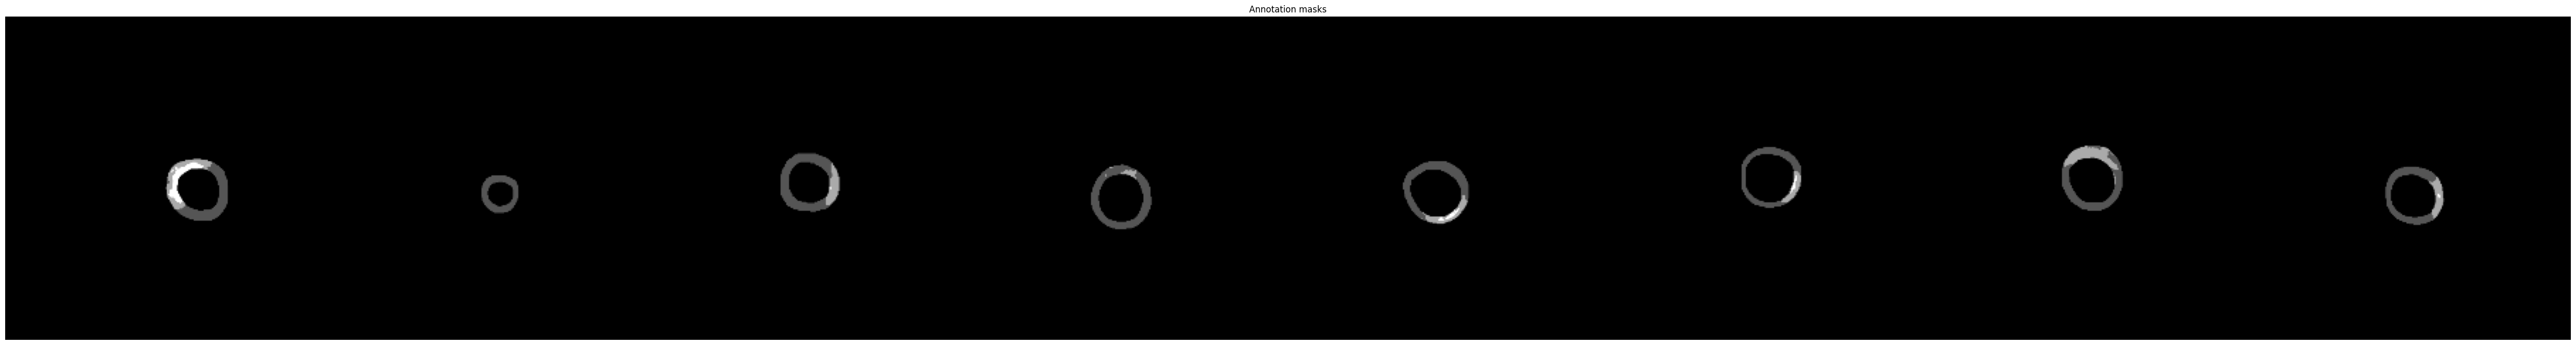

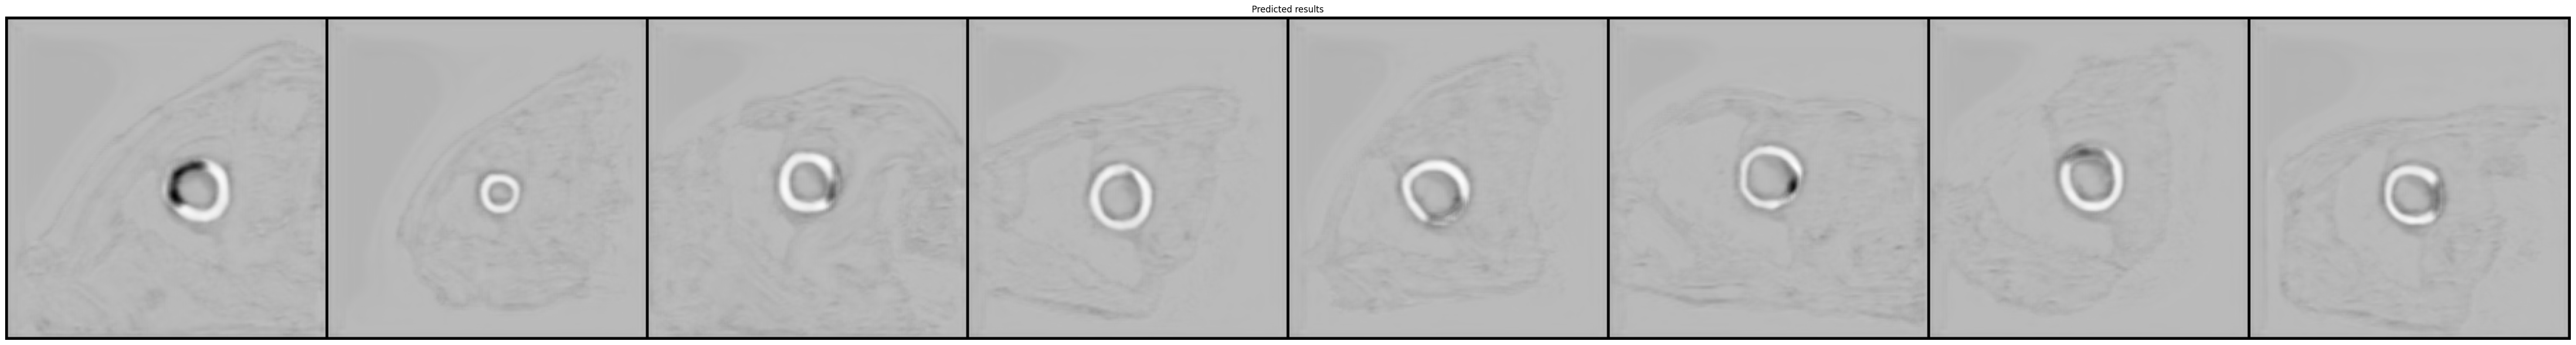

In [ ]:
#Visualizations of the mask, and prediction

#Show mask
plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Annotation masks")
plt.imshow(np.transpose(vutils.make_grid(mask[0:], padding=2, normalize=True).cpu(),(1,2,0)))
fig = plt.imshow(np.transpose(vutils.make_grid(mask[0:], padding=2, normalize=True).cpu(),(1,2,0)))
#fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Annotation masks V1.png", dpi=224)


#Show prediction
# here we have to use mask_pre[0:,1].unsqueeze(1) - select 2nd channel as mask output and add one more dimension for 16,1,224,224 for image display
plt.figure(figsize=(64,64))
plt.axis("off")
plt.title("Predicted results")
plt.imshow(np.transpose(vutils.make_grid(mask_pre[0:,1].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
fig = plt.imshow(np.transpose(vutils.make_grid(mask_pre[0:,1].unsqueeze(1), padding=2, normalize=True).cpu(),(1,2,0)))
#fig.figure.savefig("/content/drive/My Drive/Internship_24_Ryan/Script/Brain MRI/exp_2_ground_label_seg/results/Fully S-multiclass-smploss-s1/Predicted results V1.png", dpi=224)


In [ ]:
#In use for colab, downgrade pandas here for later evaluation code
!pip3 install pandas==1.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [ ]:
#IMport libraries
import os
import numpy as np
import pandas as pd

# specify the folder path for testing dataset
directory = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine'

# number of file in directory
dirListing = os.listdir(directory)
row_num = len(dirListing)

# load empty excel file for recording filename
df = pd.read_csv(
    "/content/drive/My Drive/Internship_24_Ryan/Heart/Temp/Filename.csv")




#Most of the below code from 'for i in range(row_num)' to 'df_final.to_csv' is outdated and reduntant - don't believe its actually useful later"

# add blank row to df for saving ID

for i in range(row_num):
    df = df.append({'ID': i}, ignore_index=True)
df_temp = df

# write ID to final excel file
df_final = df_temp
counter = 0
for filename in os.listdir(directory):
    if filename.endswith(".tiff"):
        df_final['ID'][counter] = filename
        counter += 1

        continue
    else:
        continue

df_final.to_csv(
    '/content/drive/My Drive/Internship_24_Ryan/Heart/Temp/Filename filled.csv',
    index=False)

<ipython-input-18-60b8b3ffa1bc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-18-60b8b3ffa1bc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-18-60b8b3ffa1bc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-18-60b8b3ffa1bc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'ID': i}, ignore_index=True)
<ipython-input-18-60b8b3ffa1bc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

In [ ]:
from types import NoneType

# total number of testing dataset
length = df['ID'].size

# other customized DICE calculation fuction - not in use
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true) == 0) and (np.sum(y_pred_bin) == 0):
        return 1
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

# other customized DICE calculation fuction - not in use
def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width, n_channels)
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for j in range(channel_num):
        channel_dice = single_dice_coef(y_true[:, :, j], y_pred_bin[:, :, j])
        mean_dice_channel += channel_dice / (channel_num)
    return mean_dice_channel

# standard DICE calculation fuction
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union == 0:
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
    score = 2. * intersection / union
    #print(score)
    return 2. * intersection / union



In [ ]:
#Import libraries
from scipy.stats import logistic
import gc

#Define variables for average dice coefficient score
score_1 = 0
count = 0
i = 0
lst = []

#Define the total amount of accuracy for each of the labels and the count of each label for individual label accuracy
label_1 = 0
label_2 = 0
label_3 = 0
count_1 = 0
count_2 = 0
count_3 = 0



#Define paths for the test images
img_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
mask_path_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'


#Define testing dataset
test_set_phx = My_Datasets(img_path_test, mask_path_test, transform1=transforms_img, transform2=transforms_mask)
n_test = len(test_set_phx)
test_loader_phx = Data.DataLoader(dataset=test_set_phx,num_workers=0,batch_size=1,pin_memory=True)

#Calculate avg dice score and individual label dice score
for i, (image, mask, filename) in enumerate(test_loader_phx):

    #Send images and masks to GPU
    img = image.to(device=device,dtype=torch.float32)
    mask = mask.to(device=device,dtype=torch.float32)


    #Predict on images and apply softmax function for multiclass segmentation
    with torch.no_grad():
        model_test.eval()
        pre = model_test(img.cuda())
        pred = torch.softmax(pre, dim = 1)



    if type(pred) != type(None) and type(mask) != type(None):
      img_score = 0



      #Go through each label
      for layer in range(3):

        #The model returns an output of shape (4,224,224), with each of the channels being one label's prediction. For example, pred[2] defines the area that the model thinks belongs to Label 2
        #However, the mask is shape (1,224,224), with the different labels simply having different values, with the area of Label 2 being all the pixels that have value 2
        #Label 0 is the background label, the non-disease label, so we do not use it in our evaluation of the dice score

        #Get the ground truth area of the label the for loop is currently on
        temp_mask = np.where(mask.cpu().numpy() == layer+1, 1, 0)

        #Get the predicted area of the label the loop is on
        temp_pred = np.where(pred[0][layer+1].cpu().numpy() > 0.5, 1, 0)


        #Calculate the dice score
        score_temp = dice_coef2(temp_mask, temp_pred)

        #Add the dice score to the sum of all accuracies
        img_score += score_temp



        #If the label is 1, add it to the dice score sum for layer 1 and add one to the number of files that have label 1
        #Continue for all labels

        #Remember that if layer == 0, that means the Label is 1
        #Label 0 is the background layer, and Label 1-3 are heart disease labels
        if layer == 0:
          label_1 += score_temp
          count_1 += 1
        elif layer == 1:
          label_2 += score_temp
          count_2 += 1
        elif layer == 2:
          label_3 += score_temp
          count_3 += 1

      #Divide the image score by 3 for each of the labels
      final_img_score = img_score/3

      #Add it to a list
      lst += [[final_img_score, df['ID'][i]]]

      #Add final_img_score to score_1, which is the current avg dice coefficient across all images
      score_1 = score_1 + final_img_score
      count += 1
    else:
      print(i)


#Print results

print("Dice Coefficient", score_1/count)
print("Label 1 score: ", label_1/count_1)
print("Label 2 score: ", label_2/count_2)
print("Label 3 score: ", label_3/count_3)

Dice Coefficient 0.6238675260572696
Label 1 score:  0.7324664292550019
Label 2 score:  0.4871906859744433
Label 3 score:  0.6519454629423627


In [ ]:
#The below code attempts to visualize the predictions, but it has a few errors.

In [ ]:
LGE_test_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/LGE/'
cine_test_path = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/Cine/'
ground_test = '/content/drive/My Drive/Internship_24_Ryan/Heart/Data/test/masks/'

test_set = My_Datasets(cine_test_path,ground_test, transform1=transforms_img,transform2=transforms_mask)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

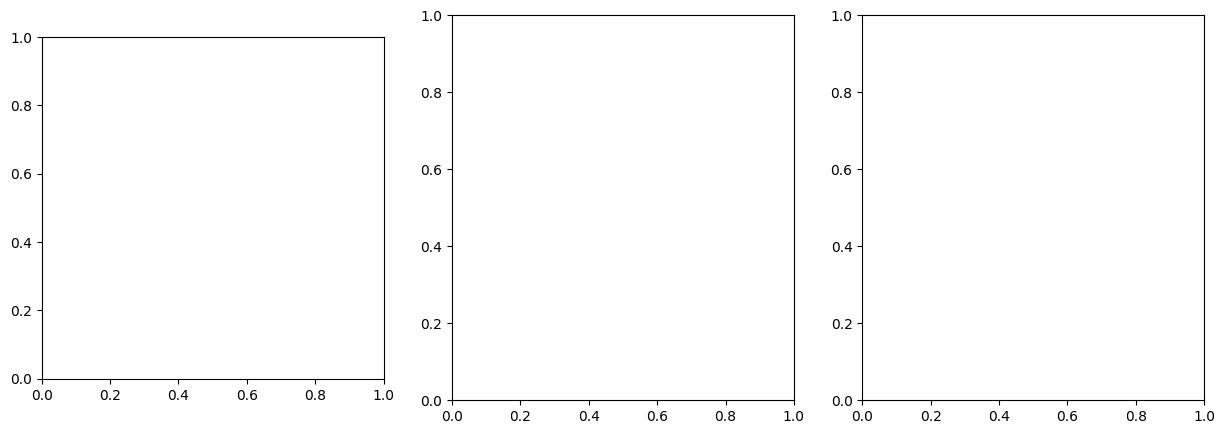

In [ ]:
from operator import itemgetter
lst = sorted(lst, key=itemgetter(0))
lst = [[round(pair[0], 3), pair[1]] for pair in lst]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i in range(3):
  #change index here
  index = (i)+50

  name = lst[index][1]
 # here we load as RBG
  cine = test_set[index][0] # here we load as RBG

  gro_mask= test_set[index][1] # here we load as RBG



  pred_mask = model_test(cine.unsqueeze(0))

  axes[i].imshow(pred_mask)
  axes[i].axis('off')  # Hide axis
  #axes[i].set_title(f"Accuracy: {lst[inverse][0]}")